In [235]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [226]:
####### ODES ######
def ode_rho_m(t, y: tuple, r, l, pi):
    rho, m = y
    drho_dt = (1-rho)*(2*pi + l/2*(rho**2+m**2)) - r*rho
    dm_dt = l*(1-rho)*rho*m - r*m
    return drho_dt, dm_dt

def fs_evo_eq(t,fs,r,l,pi):
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        dfdt = fs[0]*(pi+l*fs[site_i]**2) - r*fs[site_i]
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt
####################

def poly3_rho_param_m(rho, r,l,pi,m):
    a, b = 1, -1
    c = 2*r/l + m**2
    d = -4*pi - m**2
    return a*rho**3 + b*rho**2 + c*rho + d

def poly3_rho_param_m_sols(r, l, pi, m):
    a, b = 1, -1
    c = 2*r/l + m**2
    d = -4*pi - m**2
    # step 1: delta0 and elta 1
    delta0 = b**2 - 3*a*c
    delta1 = 2*b**3 - 9*a*b*c + 27*a**2*d
    # step 2: computation of C:
    if delta0 == 0.0 and delta1 != 0.0:
        C = delta1**(1/3) # cubic_root[(delta1 + sqrt(delta1**2+0))/2]
    elif delta0 == 0.0 and delta1 == 0.0:
        C = 1.0 # so in the next step delta0/C yields 0.0 instead of NaN (0.0/0.0)
    else:
        radicand0 = delta1**2 - 4*delta0**3
        if radicand0 < 0:
            root0 = complex(0,np.sqrt(-1*radicand0))
        else:
            root0 = complex(np.sqrt(radicand0),0)
        radicand1 = (delta1 + root0)/2
        C = radicand1**(1/3)
    # 3: Final solution
    ksi = complex(-1, np.sqrt(3))/2
    roots, roots_Re = [], []
    for k in range(3):
        f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
        roots.append(f0_root), roots_Re.append(f0_root.real)
    return roots_Re, roots


# when m=0, this is the poly we have to solve for rho:
def poly3_rho_m0(rho, r, l, pi):
    a, b = -l/2, l/2
    c = -2*pi - 1
    d = 2*pi
    return a*rho**3 + b*rho**2 + c*rho + d

def poly3_rho_m0_sols(r, l, pi):
    a, b = -l/2, l/2
    c = -2*pi - 1
    d = 2*pi
    # step 1: delta0 and elta 1
    delta0 = b**2 - 3*a*c
    delta1 = 2*b**3 - 9*a*b*c + 27*a**2*d
    # step 2: computation of C:
    if delta0 == 0.0 and delta1 != 0.0:
        C = delta1**(1/3) # cubic_root[(delta1 + sqrt(delta1**2+0))/2]
    elif delta0 == 0.0 and delta1 == 0.0:
        C = 1.0 # so in the next step delta0/C yields 0.0 instead of NaN (0.0/0.0)
    else:
        radicand0 = delta1**2 - 4*delta0**3
        if radicand0 < 0:
            root0 = complex(0,np.sqrt(-1*radicand0))
        else:
            root0 = complex(np.sqrt(radicand0),0)
        radicand1 = (delta1 + root0)/2
        C = radicand1**(1/3)
    # 3: Final solution
    ksi = complex(-1, np.sqrt(3))/2
    roots, roots_Re = [], []
    for k in range(3):
        f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
        roots.append(f0_root), roots_Re.append(f0_root.real)
    return roots_Re, roots


####### LSA #######
def LSA_matrix(sol, r, l, pi):
    # sol = (rho, m)
    rho, m = sol
    a11 = (1-rho)*rho*l - 2*pi - l/2*(rho**2 + m**2) - r
    a12 = (1-rho)*m*l
    a21 = l*(1-rho)*m + l*rho*m
    a22 = l*(1-rho)*rho - r
    return np.array([[a11, a12], [a21, a22]])

def LSA_matrix_fs(falphas, r, l, pi):
    # falphas do not contain f0!!!
    mat = []
    f0 = 1 - sum(falphas)
    for i in range(len(falphas)):
        row = []
        for j in range(len(falphas)):
            if i == j:
                row.append( 2*l*f0*falphas[i] - r - pi - l*falphas[i] )
            else:
                row.append( -pi-l*falphas[i]**2 )
        mat.append(row)
    return np.array(mat)


In [227]:
pi = 0
r, l = 0.2, 1

# rho, m = (1+np.sqrt(1-8*r/l))/2, 0
# rho, m = (1-np.sqrt(1-8*r/l))/2, 0
# rho, m = 0, 0

# one species solutions brought here
# rho = (1+np.sqrt(1-4*r/l))/2
rho = (1-np.sqrt(1-4*r/l))/2
m = rho # or -rho


valODEs = ode_rho_m(0, (rho, m), r, l, pi)
print(f'dot_m = {valODEs[1]}, dot_rho = {valODEs[0]}')

# LSA:
lsa_mat = LSA_matrix((rho, m), r, l, pi)
eigvals = np.linalg.eig(lsa_mat)[0]
print(eigvals)

f1, f2 = rho, 0
# f1, f2 = 0, rho
# f1, f2 = rho/2, rho/2
valODEs = fs_evo_eq(0, (1-f1-f2, f1, f2), r, l, pi)
print(f'dot_f0 = {valODEs[0]}, dot_f1 = {valODEs[1]}, dot_f2 = {valODEs[2]}')
lsa_mat_fs = LSA_matrix_fs((f1, f2), r, l, pi)
eigvals = np.linalg.eig(lsa_mat_fs)[0]
print(eigvals)

dot_m = 0.0, dot_rho = 0.0
[-0.2763932  0.2      ]
dot_f0 = -0.0, dot_f1 = 0.0, dot_f2 = 0.0
[-0.0763932 -0.2      ]


In [228]:
pi, r, l = 1.0, 0.1, 6.5
rho_m_t0 = [0.5, 0.1]
sol = solve_ivp(ode_rho_m, [0, 2000], rho_m_t0, args=(r, l, pi))

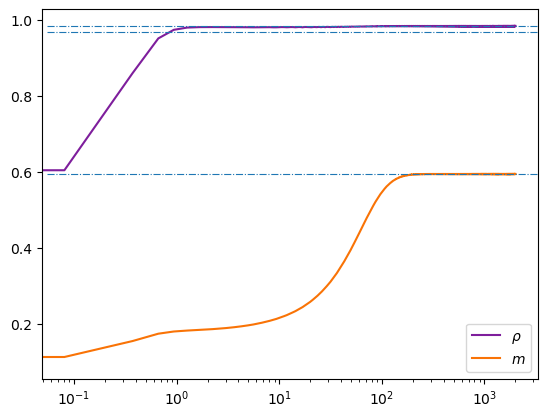

In [229]:
fig, ax = plt.subplots()

ax.plot(sol.t, sol.y[0], color='xkcd:purple', label=r'$\rho$')
ax.plot(sol.t, sol.y[1], color='xkcd:orange', label=r'$m$')

# lines for rho
rho_1op = (1+np.sqrt(1-4*r/l))/2
rho_2op = (1+np.sqrt(1-8*r/l))/2
ax.axhline(rho_1op, xmin=0.01, xmax=sol.t[-1], lw=0.8, ls='-.')
ax.axhline(rho_2op, xmin=0.01, xmax=sol.t[-1], lw=0.8, ls='-.')

# lines for m
m = np.sqrt(rho_1op**2 - 4*pi/l)
ax.axhline(m, xmin=0.01, xmax=sol.t[-1], lw=0.8, ls='-.')

ax.legend()
ax.set_xscale('log')

In [230]:
r, l, pi = 0.1, 1, 0.0
r, l, pi = 0.2, 1, 0.0

fs0 = [0.0,0.6,0.4] # goes to the single species stationary point
fs0 = [0.0, 0.51, 0.49] # same

# fs0 = [0.0, 0.5, 0.5] # goes to the 2 species stationary point but with the active population equiditributed between the two sites

# rho = (1+np.sqrt(1-8*r/l))/2
# fs0 = [1-rho, rho, 0.0]

# one option solution:
rho_single_species = (1+np.sqrt(1-4*r/l))/2
fs0 = [1-rho_single_species, rho_single_species, 0.0]

sol = solve_ivp(fs_evo_eq, [0,2000], fs0, args=(r, l, pi))

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/52363.py:7: RuntimeWarning: invalid value encountered in sqrt
  rho = (1+np.sqrt(1-8*r/l))/2


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff6a8f783a0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

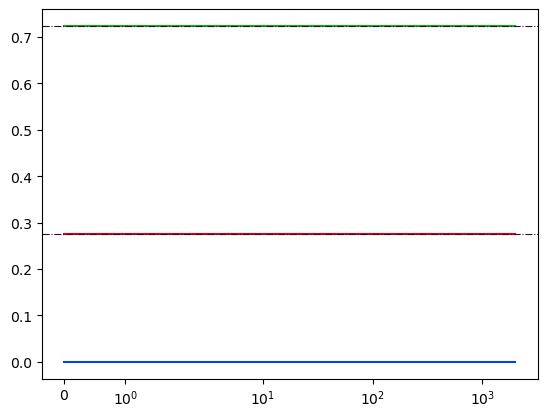

In [231]:
fig, ax = plt.subplots()
ax.set(xscale='symlog')
ax.plot(sol.t, sol.y[0], color='xkcd:red')
ax.plot(sol.t, sol.y[1], color='xkcd:green')
ax.plot(sol.t, sol.y[2], color='xkcd:blue')

rho = (1+np.sqrt(1-8*r/l))/2
rho_single_species = (1+np.sqrt(1-4*r/l))/2

ax.axhline(rho, 0, 1, color='xkcd:mauve', lw=0.8, ls='-.')
ax.axhline(rho_single_species, 0, 1, color='xkcd:dark purple', lw=0.8, ls='-.')

f0 = 1 - rho
f0_single_species = 1 - rho_single_species
ax.axhline(f0, 0, 1, color='xkcd:mauve', lw=0.8, ls='-.')
ax.axhline(f0_single_species, 0, 1, color='xkcd:dark purple', lw=0.8, ls='-.')

# rho_equi = rho/2
# ax.axhline(rho_equi, 0, 1, color='xkcd:gray', lw=0.8, ls='-.')

# Pi > 0

In [233]:
r, pi = 1, 0.02
# Valid lambdas for m solution given pi:
lm = (4*pi + 1)**2/(4*pi)

print(lm)

14.580000000000002


In [212]:
ls = np.arange(1,8,0.1)
r = 1

pi_small, pi_large = 0.05, 1.0

rho_m_t0 = [0.5, 0.1]
rho_m_int_pi_large = [[], []]
rho_m_int_pi_small = [[], []]

for l in ls:
    # integrate equations:
    pi = pi_large
    sol = solve_ivp(ode_rho_m, [0, 2000], rho_m_t0, args=(r, l, pi))
    rho_m_int_pi_large[0].append(sol.y[0][-1]), rho_m_int_pi_large[1].append(sol.y[1][-1])
    pi = pi_small
    sol = solve_ivp(ode_rho_m, [0, 2000], rho_m_t0, args=(r, l, pi))
    rho_m_int_pi_small[0].append(sol.y[0][-1]), rho_m_int_pi_small[1].append(sol.y[1][-1])

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3320748391.py:16: RuntimeWarning: invalid value encountered in sqrt
  rho_theo = [(1+np.sqrt(1-4*r/l))/2 for l in ls]
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3320748391.py:23: RuntimeWarning: invalid value encountered in sqrt
  rho_theo = [(1+np.sqrt(1-4*r/l))/2 for l in ls]
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3320748391.py:24: RuntimeWarning: invalid value encountered in sqrt
  mtheo = [np.sqrt(rho**2 - 4*pi/l) for rho,l in zip(rho_theo, ls)]


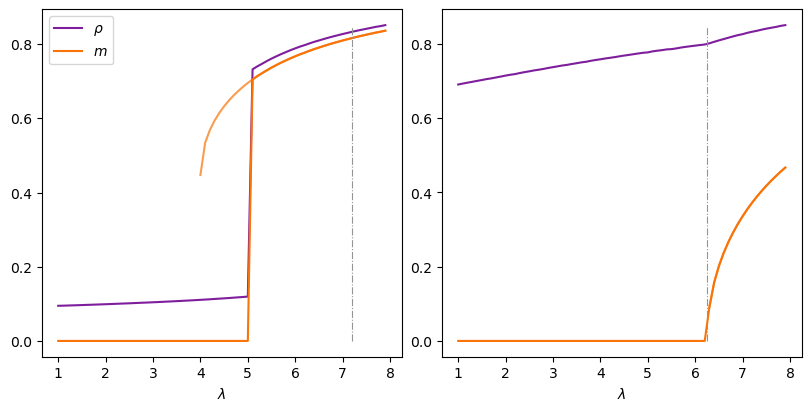

In [140]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))
ax[0].set(xlabel='$\lambda$')
ax[1].set(xlabel='$\lambda$')

ax[0].plot(ls, rho_m_int_pi_small[0], label=r'$\rho$', color='xkcd:purple')
ax[0].plot(ls, rho_m_int_pi_small[1], label=r'$m$', color='xkcd:orange')
ax[0].legend()

ax[1].plot(ls, rho_m_int_pi_large[0], label=r'$\rho$', color='xkcd:purple')
ax[1].plot(ls, rho_m_int_pi_large[1], label=r'$m$', color='xkcd:orange')

ax[0].text(0.3, 0.9, rf'$\pi = {pi_small}$', transform=ax[0].transAxes)
ax[1].text(0.3, 0.9, rf'$\pi = {pi_large}$', transform=ax[1].transAxes)

# theoretical solutions and thresholds:

pi = pi_small
lm = (4*pi + 1)**2/(4*pi)
rho_theo = [(1+np.sqrt(1-4*r/l))/2 for l in ls]
mtheo = [np.sqrt(rho**2 - 4*pi/l) for rho,l in zip(rho_theo, ls)]
ax[0].plot(ls, mtheo, color='xkcd:orange', alpha=0.7)
ax[0].vlines(lm, 0.0, 0.85, lw=0.8, ls='-.', color='xkcd:gray')

pi = pi_large
lm = (4*pi + 1)**2/(4*pi)
rho_theo = [(1+np.sqrt(1-4*r/l))/2 for l in ls]
mtheo = [np.sqrt(rho**2 - 4*pi/l) for rho,l in zip(rho_theo, ls)]
ax[1].plot(ls, mtheo, color='xkcd:orange', alpha=0.7)
ax[1].vlines(lm, 0.0, 0.85, lw=0.8, ls='-.', color='xkcd:gray')

In [175]:
# poly3_rho_m0_sols(1, 6.6, 0.05)
r, pi = 1, 0.05
solsRe, solsIM = poly3_rho_m0_sols(r, 7.6, pi)

print(solsRe)
print(solsIM)

[0.577877967615815, 0.21106101619209253, 0.21106101619209253]
[(0.577877967615815+0j), (0.21106101619209253+0.03149459468635048j), (0.21106101619209253-0.03149459468635048j)]


# Theoretical Solutions pi>0

In [326]:
r, l, pi = 1, 6.5, 0.02
rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)

lsa_mat_p = LSA_matrix((rhop, mp), r, l, pi)
lsa_mat_m = LSA_matrix((rhom, mm), r, l, pi)
eigvals_p = np.linalg.eig(lsa_mat_p) #[0]
eigvals_m = np.linalg.eig(lsa_mat_m)[0]
print('Eigvals rho plus ', eigvals_p)
print('Eigvals rho minus ', eigvals_m)

# m 0 sol in this regime:
solsRe, solsIM = poly3_rho_m0_sols(r, l, pi)
for sol in solsIM:
    if abs(sol.imag) < 1e-8:
        lsa_mat_p = LSA_matrix((sol.real, 0), r, l, pi)
        eigvals_p = np.linalg.eig(lsa_mat_p)[0]
        print(f'Eigvals rho = {round(sol.real,8)}, m=0 ', eigvals_p)

Eigvals rho plus  (array([-5.24976306,  0.98419863]), array([[-0.70938741, -0.18541814],
       [ 0.70481878, -0.98265971]]))
Eigvals rho minus  [-1.02657493  0.79213936]
Eigvals rho = 0.04433053, m=0  [-0.7710122  -0.72462532]


In [210]:
r, l, pi = 1, 6.5, 0.5
rhop = (1+np.sqrt(1-4*r/l))/2
mp = np.sqrt(rhop**2 - 4*pi/l)

lsa_mat_p = LSA_matrix((rhop, mp), r, l, pi)
eigvals_p = np.linalg.eig(lsa_mat_p)[0]
print(eigvals_p)


# m 0 sol in this regime:
solsRe, solsIM = poly3_rho_m0_sols(r, l, pi)
real_parts = []
for sol in solsIM:
    if abs(sol.imag) < 1e-8:
        real_parts.append(sol.real)
lsa_mat_p = LSA_matrix((real_parts[0], 0), r, l, pi)
eigvals_p = np.linalg.eig(lsa_mat_p)[0]
print(eigvals_p)

[-4.84303189  0.57746746]
[-2.47480021  0.2718368 ]


In [237]:
# pi_small, pi_large = 0.01, 0.26
pi_small, pi_large = 0.02, 0.26
# pi_small, pi_large = 0.05, 0.5
# pi_small, pi_large = 0.1, 1.0

In [238]:
# ls = np.arange(1,8,0.01)
# ls = np.arange(1,32,0.01) # pi = 0.01
ls = np.arange(1,17,0.01) # pi = 0.02
r = 1

rho_m_plus_pi_small = [[], []]
rho_m_plus_pi_large = [[], []]
rho_m_minus_pi_small = [[], []]
rho_m_minus_pi_large = [[], []]

# pi small
pi = pi_small
for l in ls:
    rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
    mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)
    rho_m_plus_pi_small[0].append(rhop), rho_m_plus_pi_small[1].append(mp)
    rho_m_minus_pi_small[0].append(rhom), rho_m_minus_pi_small[1].append(mm)

# pi large
pi = pi_large
for l in ls:
    rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
    mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)
    rho_m_plus_pi_large[0].append(rhop), rho_m_plus_pi_large[1].append(mp)
    rho_m_minus_pi_large[0].append(rhom), rho_m_minus_pi_large[1].append(mm)

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3546323489.py:14: RuntimeWarning: invalid value encountered in sqrt
  rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3546323489.py:15: RuntimeWarning: invalid value encountered in sqrt
  mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3546323489.py:22: RuntimeWarning: invalid value encountered in sqrt
  rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3546323489.py:23: RuntimeWarning: invalid value encountered in sqrt
  mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)


In [241]:
rho_m0_pi_small = [[], []]
rho_m0_pi_large = [[], []]

r = 1
# pi small
pi = pi_small
# ls_m0 = np.arange(1,32,0.1)
ls_m0 = np.arange(1,17,0.1)
ls_m0 = np.around(ls_m0, 8)
for l in ls_m0:
    if l == 6.6:
        solsRe, solsIM = poly3_rho_m0_sols(r, 6.6, pi)
    else:
        solsRe, solsIM = poly3_rho_m0_sols(r, l, pi)
    real_parts = []
    for sol in solsIM:
        if abs(sol.imag) < 1e-8:
            real_parts.append(sol.real)
    if len(real_parts) > 1:
        print(round(l,8), pi)
        print(solsIM)
    if len(real_parts) == 0:
        print(round(l,8), pi)
        print(solsIM)
    rho_m0_pi_small[0].append(real_parts[0])
    rho_m0_pi_small[1].append(0.0)

# pi large
pi = pi_large
for l in ls_m0:
    solsRe, solsIM = poly3_rho_m0_sols(r, l, pi)
    real_parts = []
    for sol in solsIM:
        if abs(sol.imag) < 1e-8:
            real_parts.append(sol.real)
    if len(real_parts) > 1:
        print(l, pi)
        print(solsIM)
    if len(real_parts) == 0:
        print(l, pi)
        print(solsIM)
    rho_m0_pi_large[0].append(real_parts[0])
    rho_m0_pi_large[1].append(0.0)

7.7 0.02
[(0.512286983357527+1.922464111905033e-17j), (0.04590409848309629-4.806160279762582e-18j), (0.44180891815937673+3.844928223810066e-17j)]
7.8 0.02
[(0.5460155633856199+0j), (0.0460464572856719+0j), (0.40793797932870823+3.7956342722227575e-17j)]
7.9 0.02
[(0.5674808238836656+0j), (0.04619075318662607+0j), (0.3863284229297083+3.7475882687768996e-17j)]
8.0 0.02
[(0.5843404487333674+0j), (0.04633703787941973-1.850371707708594e-17j), (0.3693225133872128+3.700743415417188e-17j)]
8.1 0.02
[(0.5985435738224854-3.6550552251033966e-17j), (0.046485365179015144-9.137638062758492e-18j), (0.3549710609984997+7.310110450206793e-17j)]
8.2 0.02
[(0.6109511858432254-1.8052406904474093e-17j), (0.04663579114120863-9.026203452237046e-18j), (0.34241302301556603-3.6104813808948186e-17j)]
8.3 0.02
[(0.6220359111897145-1.7834908026106932e-17j), (0.04678837419057489-3.5669816052213865e-17j), (0.33117571461971074+1.4267926420885546e-16j)]
8.4 0.02
[(0.632091241261502+1.76225876924628e-17j), (0.04694317525

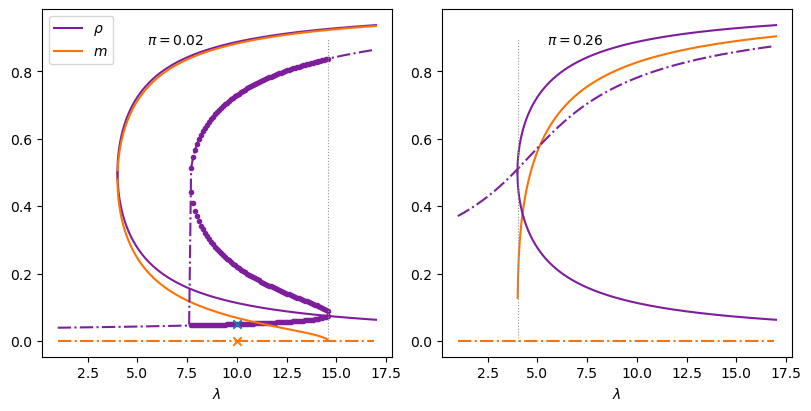

In [256]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))
ax[0].set(xlabel='$\lambda$')
ax[1].set(xlabel='$\lambda$')

ax[0].text(0.3, 0.9, rf'$\pi = {pi_small}$', transform=ax[0].transAxes)
ax[1].text(0.3, 0.9, rf'$\pi = {pi_large}$', transform=ax[1].transAxes)

ax[0].plot(ls, rho_m_plus_pi_small[0], label=r'$\rho$', color='xkcd:purple')
ax[0].plot(ls, rho_m_plus_pi_small[1], label=r'$m$', color='xkcd:orange')

ax[0].plot(ls, rho_m_minus_pi_small[0], color='xkcd:purple')
ax[0].plot(ls, rho_m_minus_pi_small[1], color='xkcd:orange')

ax[0].plot(ls_m0, rho_m0_pi_small[0], ls='-.', color='xkcd:purple')
ax[0].plot(ls_m0, rho_m0_pi_small[1], ls='-.', color='xkcd:orange')
ax[0].legend()

ax[1].plot(ls, rho_m_plus_pi_large[0], label=r'$\rho$', color='xkcd:purple')
ax[1].plot(ls, rho_m_plus_pi_large[1], label=r'$m$', color='xkcd:orange')

ax[1].plot(ls, rho_m_minus_pi_large[0], color='xkcd:purple')
ax[1].plot(ls, rho_m_minus_pi_large[1], color='xkcd:orange')

ax[1].plot(ls_m0, rho_m0_pi_large[0], ls='-.', color='xkcd:purple')
ax[1].plot(ls_m0, rho_m0_pi_large[1], ls='-.', color='xkcd:orange')

ax[0].vlines((4*pi_small+1)**2/(4*pi_small), 0, 0.9, ls=':', color='xkcd:gray', lw=0.8)
ax[1].vlines((4*pi_large+1)**2/(4*pi_large), 0, 0.9, ls=':', color='xkcd:gray', lw=0.8)

# special for pi = 0.05
if pi_small == 0.05 or pi_small == 0.01 or pi_small == 0.02:
    ls_dic = {0.05: [7.1, 7.2, 7.3, 7.4, 7.5], 0.01: np.arange(7.9, 27.1, 0.1), 0.02: np.arange(7.7, 14.7, 0.1)}
    for l in ls_dic[pi_small]:
        solsRe, solsIM = poly3_rho_m0_sols(r, l, pi_small)
        for sol in solsRe:
            if abs(solsIM.imag) < 1e-8:
                ax[0].scatter(l, sol, color='xkcd:purple', marker='.')

# ax.plot(ls, mps)
# ax.plot(ls, mms)
# ax.vlines((4*pi+1)**2/(4*pi), 0, 1, lw=0.8, ls='-.', color='xkcd:gray')

ax[0].scatter(10.0, 0.04976555276997916, marker='x')
ax[0].scatter(10.0, 0.0, marker='x')

# fig.savefig(f'bifurcations_pi_small_{pi_small}_pi_large_{pi_large}.png')

In [284]:
pi, r, l = 0.02, 1, 16.0

# different initial conditions:
rho_m_t0 = [0.01, 0.01] # to m0 lowest sol
# rho_m_t0 = [0.6, 0.0] # to m0 highest sol

# rho_m_t0 = [0.6, 1e-5] # to m neq 0 highest sol
# rho_m_t0 = [0.6, 0.01] # to m neq 0 highest sol

rho_m_to = [1.0, 0.01]

sol = solve_ivp(ode_rho_m, [0, 2000], rho_m_t0, args=(r, l, pi))
print(sol.y[0][-1], sol.y[1][-1])

0.9327955422726161 0.9301130764881841


In [285]:
ode_rho_m(0, (1.0, 0.01), r, l, pi)

(-1.0, -0.01)

### Flow map in the (rho, m) space

In [317]:
def get_maker_colors(eigvals):
    if eigvals[0] > 0 and eigvals[1] > 0: # unstable
        color, edgecolor = 'xkcd:red', 'xkcd:red'
    elif np.sign(eigvals[0]) != np.sign(eigvals[1]): # saddle node
        color, edgecolor = 'xkcd:tangerine', 'xkcd:tangerine'
    elif eigvals[0] < 0 and eigvals[1] < 0:
        color, edgecolor = 'xkcd:black', 'xkcd:black'
    else:
        color, edgecolor = 'xkcd:pink', 'xkcd:pink'
    return color, edgecolor

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/2906938490.py:23: RuntimeWarning: invalid value encountered in sqrt
  mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/2906938490.py:45: RuntimeWarning: invalid value encountered in divide
  drho_grid = drho_grid/norm
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/2906938490.py:46: RuntimeWarning: invalid value encountered in divide
  dm_grid = dm_grid/norm


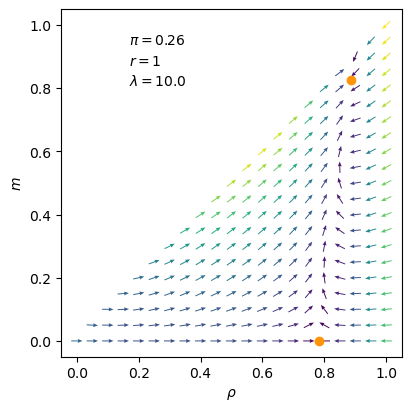

In [324]:
# pi, r, l = 0.02, 1, 2.5
pi, r, l = 0.26, 1, 10.0

fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
ax.set(xlabel=r'$\rho$', ylabel=r'$m$')
ax.text(0.2, 0.9, rf'$\pi = {pi}$', transform=ax.transAxes)
ax.text(0.2, 0.84, rf'$r = {r}$', transform=ax.transAxes)
ax.text(0.2, 0.78, rf'$\lambda = {l}$', transform=ax.transAxes)

# find the solutions and scatter them:

# m == 0 solutions:
solsRe, solsIM = poly3_rho_m0_sols(r, l, pi)
for sol in solsIM:
    if abs(sol.imag) < 1e-8:
        lsa_mat = LSA_matrix((sol.real, 0), r, l, pi)
        eigvals = np.linalg.eig(lsa_mat)[0]
        color, edgecolor = get_maker_colors(eigvals)
        ax.scatter(sol.real, 0, color=color, edgecolor=edgecolor, marker='o')

# m != solutions:
rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)

for sol in [(rhop, mp), (rhom, mm)]:
    if not np.isnan(sol[0]) and not np.isnan(sol[1]):
        lsa_mat = LSA_matrix((sol[0], sol[1]), r, l, pi)
        eigvals = np.linalg.eig(lsa_mat)[0]
        color, edgecolor = get_maker_colors(eigvals)
        ax.scatter(sol[0], sol[1], color=color, edgecolor=edgecolor, marker='o')

# arrows mesh:
h = 0.05
rho_grid, m_grid= np.meshgrid(np.arange(0, 1+h, h), np.arange(0, 1+h, h))
drho_grid, dm_grid = np.zeros_like(rho_grid), np.zeros_like(m_grid)

for i,rho in enumerate(rho_grid[0]): # rho_grid[0] is a row (so i labels the columns)
    for j,m in enumerate(m_grid[:,0]): # m_grid[:,0] is a column (so j labels the rows)
        if m <= rho:
            drho, dm = ode_rho_m(0, (rho, m), r, l, pi)
            drho_grid[j,i] = drho
            dm_grid[j,i] = dm

norm = np.sqrt(drho_grid**2 + dm_grid**2)
drho_grid = drho_grid/norm
dm_grid = dm_grid/norm

ax.quiver(rho_grid, m_grid, drho_grid, dm_grid, norm, scale=30, pivot='mid', headwidth=4, zorder=-1)

fig.savefig(f'flow_map_rho_m_r_{r}_l_{l}_pi_{pi}.png')